# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=(2**16),alternate_sign=False, ngram_range = (1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['exclaim_count'] = toxic_data["comment_text"].str.count("\!")

    X_quant_features = toxic_data[["word_count", "punc_count", "exclaim_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_train.csv', my_random_seed=95)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 6649, 'TN': 57141, 'FP': 57513, 'FN': 6353, 'Accuracy': 0.4997023249984333, 'Precision': 0.10362831582556653, 'Recall': 0.5113828641747423, 'desc': 'ols_train'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12978, 'TN': 114637, 'FP': 17, 'FN': 24, 'Accuracy': 0.9996788243404149, 'Precision': 0.9986918045402078, 'Recall': 0.9981541301338256, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12981, 'TN': 114638, 'FP': 16, 'FN': 21, 'Accuracy': 0.9997101585511061, 'Precision': 0.998768946680003, 'Recall': 0.9983848638670973, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12196, 'TN': 106283, 'FP': 8371, 'FN': 806, 'Accuracy': 0.9281114871216394, 'Precision': 0.5929887684154228, 'Recall': 0.9380095369943086, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12959, 'TN': 114644, 'FP': 10, 'FN': 43, 'Accuracy': 0.9995848217083412, 'Precision': 0.9992289305266404, 'Recall': 0.9966928164897708, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12576, 'TN': 114605, 'FP': 49, 'FN': 426, 'Accuracy': 0.9962790624804161, 'Precision': 0.9961188118811881, 'Recall': 0.9672358098754038, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 0, 'TN': 114654, 'FP': 0, 'FN': 13002, 'Accuracy': 0.8981481481481481, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/isabelstoddart/Desktop/ML/myWork/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

In [12]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: train set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
66
Removed link to website
This website

http://www.pazsaz.com/kkat.html Krazy Kat Cartoons from the 1960s - A list of Krazy Kat cartoons in full-colors. 

Was listed and it's full of pop up windows and spammy links. It may be a good source but it'll open a lot of pop up windows before you get to it and that'll crash your computer. So I moved it to the reference page so if someone wants to see the list they can but be forwarned of the pop up ads
66.99.3.100  eric
* * * * * * * * * 
275
I have explained my rationale. But where is yours?
* * * * * * * * * 
283
Oh you can bet your marathon medal that I will have it recreated. Again and again. Either I will or somebody else will when the new film starts production. I'll keep you busy for an eternity. You're talking nonsense. I dont need any of those things to verify Mr. Hunter's films. IMDB employs a vigorous verifying process. I urge you to buy copies of Mr. Hunter's films and watch them yourself. That should 

2234
Ideally, the amount of weight given to a topic should relate to whether it has reliable sources to support its importance.  If you've been doing research related to this topic, you are probably ideally situated to improve the article.  Just be sure to cite your sources.
* * * * * * * * * 
2240
we are appointed to edit and write about her ..please stop insulting it is not professional and stop editing our work on her.  We were approved way before you were on here.  and are writing it better than yours. stop writing on our work it is not proper. GFC
* * * * * * * * * 
2273
its not my interpretation. that episode is themed after the manga which is shown there as well. 

72.185.61.209
* * * * * * * * * 
2321
Please stop your disruptive editing. If you continue to vandalize Wikipedia, as you did at Frank Lampard, you will be blocked from editing.    
If this is a shared IP address, and you didn't make any unconstructive edits, consider creating an account for yourself so you can avoid 

3700
"

Reaper Eternal thanks for removing the web host block but what about the personal attacks of the editor I was responding to, calling another editors good faith edits ""trash"" several times, and no call to remove that, is that kind of editing ok with you?202.71.190.26  "
* * * * * * * * * 
3737
Functional languages: ISWIM etc.
* * * * * * * * * 
3783
"

Speedy deletion of Michael hance
 A tag has been placed on Michael hance, requesting that it be speedily deleted from Wikipedia per speedy deletion criterion A7. 

Under the criteria for speedy deletion, articles that do not meet basic Wikipedia criteria may be deleted at any time. Please see the guidelines for what is generally accepted as an appropriate article, and if you can indicate why the subject of this article is appropriate, you may contest the tagging. To do this, add  on the top of the article and leave a note on the article's talk page explaining your position. Please do not remove the speedy deletion tag yourself, 

5211
"

Cab Rider Vignette
On coming to Westport once by train , there were few cabs around 
and I shared a cab ride with Sandy Dennis, the cab dropping her off 
at her home first. (And continuing on to my inlaws in Westport.)

She was at the time in some broadway play ....

And in a continuing romantic lilt over several years, I sent to the theatre not once, but 5-6 times dozens of roses signed simply ""cab rider"" - as I liked her right away. 

She never knew who the cab rider was.

/s/ cab rider aka willy"
* * * * * * * * * 
5291
HELLO  01:39, 14 Feb 2005 (UTC)
* * * * * * * * * 
5329
"
That's been up there for a week!  I don't know how I missed that one.  >.>  '''' (Talk | Contrib)'' "
* * * * * * * * * 
5376
"

But the category Public Houses in Shropshire is a local category, not one for the ""wider scale"".   "
* * * * * * * * * 
5471
"

 hoy 

  ang galing mong mang vandal hoy kung sino ka man tiga calamba ka ba? huh? eto proweba na marong laguna west metro as defined and recogn

6934
Support per nom. (T / C / WP:FOUR / WP:CHICAGO / WP:WAWARD)
* * * * * * * * * 
7019
" 2008 (UTC)

I'm highly amazed by the fact that this debate rages on. If I may interject, Aleta formed a subsection entitled Arbitrary Page Break. Note using the word Arbitrary over say, Random? Are we going to throw a huge fuss over the inclusion of a more sophisticated word? Sobriquet is quite clearly at least somewhat different from Nickname, otherwise there would be only one article encompassing both words. My suggestion is per a growing trend on Wikipedia: Link sobriquet to a definition in Wiktionary, should one exist. This saves readers the hassle of going through an entire article trying to summarily grasp the full definition of one word within an article comprised of several thousand such words. Furthermore, if Wikipedia is meant to be an informal learning tool of sorts, why fear incorporating a higher grade-level vocabulary into it as a means of providing the best possible learning experi

8603
"

 If I remember well, British when founded the kind of Basic Law didn't rule precisely ( likely on purpose ) on which language ( spoken or written ) for Hong Kong and simply set ""Chinese"". So, one can interpret."
* * * * * * * * * 
8609
List are not copyrightable , besides I have altered them significantly, furthermore the page is not copyrighted , so quit tagging it copyvio, thank you
* * * * * * * * * 
8666
I took out a lot of biased language but somehow broke the coding in the process. I can't seem to fix it. Help, please.
* * * * * * * * * 
8711
The rules are the rules, i am entitled to make any comment here conceirning pope shenouda and i find he looks strikingly like saddam hussein. And as per wikipedia policy (for all of you who are about to strike my comment), Wikipedia:CIVIL#Removal_of_uncivil_comments, only the commentator himself can strike comments of his own. My comment does not contain any indescent language, it merely points out a fact. 77.248.185.98
* * * * * *

10246
A Disney Production Studio?
* * * * * * * * * 
10399
merger 

I think that since a sprint is a term for the same basic thing as a hackathon, it should probably be in the same article - putting it in as it's own section.  I think that hackathon is the better base article because it is a more complete article and it's an older one.  Questions?  Comments?  If I don't see any in like a week, I'll go ahead with it.
* * * * * * * * * 
10414
Image:Anaerobic digesters.jpg

This image was taken by my colleague Yair Zadik in a previous job. The creative commons license tag we viewed as the most appropriate for listing on Wikipedia.
* * * * * * * * * 
10518
REDIRECT Talk:Quetta railway station
* * * * * * * * * 
10589
Can I put brackets then?  Why do you insist this be here?
* * * * * * * * * 
10623
:Category:Wildflowers of Texas
Hi,

Would you mind if I deleted this? We already have Category:Flora of Texas, which is not presently in need of a split; wildflowers is a slippery term that coul

11660
"
List of dinosaur-age trace fossil genera to sidestep the question of whether the originating creature was really a dinosaur?  Or is that too cumbersome too?— T/C "
* * * * * * * * * 
11664
Who do you think you are.
* * * * * * * * * 
11694
not appropriate.  I however do, and so, as you sit around and waste government money reverting what I write, I too will revert what you remove.  Let me help you understand... www.youtube.com/watch?v=Y-WXPS5UlJU
* * * * * * * * * 
11777
That is a weird interpretation of WP:V. Curb Chain opens wikipedia for all kinds of gossip. /
* * * * * * * * * 
11883
"

Article subjectivity

This article's pretty terrible. I know next to nothing about Edd Gould, and I could tell you that ""an inspiration to millions of people"" doesn't fit into the editorial standards of any encyclopedia."
* * * * * * * * * 
12048
other sects.  01:45, July 29, 2005 (UTC)
* * * * * * * * * 
12061
Raggz - could you now return the text, adding these references.  Thank you.
* *

13825
also changed 'murder', because there's a great many crimes distinct from murder that result in a dead victim.  dangerous driving, criminal negligence, etc.
* * * * * * * * * 
13851
"

Any reading public can see that my previous answer was already an answer to everything Redwolf has just written. It is corrupt to accuse anyone of ""abusing Wikipedia"", whether they have or not, at the same time as blocking their ability to present the dispute to the wider ""community""(joke) on all the pages that in name exist for doing that. To have dispute-sharing sections that exist in name but blocks imposable by 1 person that prevent you using them, is an abuse of public trust and a deliberate arrangement for corruption.

Within hours of sharing this experience with outsiders who don't have a vested interest in apologism for the present regime, I have picked up confirmation that my perception is right and other public are seeing the reality. To wit: ""there do seem to be some nasty characters

17213
"
Oops, sorry about that!  I'm not very familiar with French, so forgive me.  ) -load |  "
* * * * * * * * * 
17260
REDIRECT Talk:Philippine International Hot Air Balloon Fiesta
* * * * * * * * * 
17267
, 30 April 2013 (UTC)
I'm finding it a pretty fine hour. But it's been a lousy couple of days...  (Actually, I find this kind of thing heartening:  as long as the truth emerges, finally, there's nothing wrong with the rigorous enforcement of policy.)   01:01
* * * * * * * * * 
17334
"|This boils down to: ""Administrators must not block users with whom they are engaged in a (content) dispute; "" 
Diannaa is blocking because of a hot,  one-on-one, personal conflict;  there is no evidence of disruptive editing,  any perceived ""abuse"" towards a user was one-time (and barely discussed!),  ie,  no repetition of any alleged behavior occurred.  Diannaa's block is in retailiation to a comment placed ON MY TALK PAGE (my userspace),   ""how can I disrupt my own talk page?""  commenting on 

19916
Is there an offical contemporary source were he is given that title? I.e. Diplomatic correspondence or a Vatican Publication?
* * * * * * * * * 
19957
"

Tagging
I confess I'm not sure what the standards are; if you can't find any connection, do take it out. I tend to err toward inclusion.   [[User talk:Trekphiler|hit me ♠ ]] "
* * * * * * * * * 
20081
Merged awards section 

I merged the awards section from Wikipedia:Articles for deletion/List of Black Sabbath awards.  (Shalom) Editor review
* * * * * * * * * 
20146
Whatever you think was personal, wasn't - I have no idea who who you are, or indeed who edited which bits of this article.
* * * * * * * * * 
20177
Hi! 

Hi! I see that you watch the today show and made your own template but got removed. Im sorry for that. But i put your template on my wiki (http://todayshow.wikia.com/wiki/Today_Show_Crew) it would be awesome if you could also help me edit my wiki. If you can then thank you!
* * * * * * * * * 
20183
Early WWF career 

22821
Please dont delete urtbox pages i just need to fixe information. i dont now wath is wrong whit the last messages ? ihave not put link ? thanks for your help Martin
* * * * * * * * * 
22836
"

 WikiProject WS 

Just letting you know I have created a userbox for WikiProject Writing Systems at Template:User WikiProject WS. It looks like this:

Just add {{User WikiProject WS}} to your userpage. BTW, any questions or comments should be directed to the project's talkpage, as I will be spamming this message to all current members. Thanx! ikiroid (talk)(Help Me Improve) "
* * * * * * * * * 
22913
How do you delete your own account? I want to delete and re-register. PLEASE TELL ME!
* * * * * * * * * 
22981
Well, I don't think that UNRWA promotes terrorism (and even if UNRWA did, IDF would have to give a reason why they killed Iain Hook), I do think that IDF just kills.
* * * * * * * * * 
22989
nesoi alternate definition 

NESOI is short for: Not Elsewhere Specified or Indicated.  Used in 

25627
I know that Daniel has often (and correctly) commented that the use of VP by anons (possibly vandals) might prove deleterious vis-à-vis the program's future
* * * * * * * * * 
25683
"
Phil, if you want to send the message that you support Eleland's comments, why not just give him a barnstar? I quote from you in the AN/I thread linked above ""if he posts a conciliatory unblock request that should be granted"". Where is that statement? In fact, he reiterates that he continues to think the person he called a cunt is a cunt, and that the person he called a Nazi has a Nazi style. He wrote, right above that charming cartoon above, ""IronDuke knows, full well, that I have snarkily, rhetorically, and indirectly likened the comments of one single Jewish editor to Nazi-style rhetoric - an analogy which was, given the circumstances, not a great stretch."" You aren't even pretending to get a commitment to change of behavior, Phil. It's profundly depressing.  "
* * * * * * * * * 
25726
Re: AM

28537
Who are these sceptics? 

Automatic_writing#Criticism? Can we name some names?  16:11, 23 Jun 2005 (UTC)
* * * * * * * * * 
28617
"
Nevermind. You should be flattered that he watchlists your page with each new sock! He must like you! Cheers )  talk "
* * * * * * * * * 
28636
Biography 

In 2007, A. Carlito was doing production work for local artists with his keyboards. A few months later, he was introduced by a friend who was also an producer. Around the same time, he met four friends. Vinnie, Base, Chino and Pat who were local emcees and a singer in the Connecticut area and joined to become the group known as Tru Saga. He then began DJ'ing for them at shows and produced a number of their beats on underground records.

As an up-and-coming producer, he released a album of Carlito's Way 2007. This album began what is now a regular trend. A. Carlito has a smooth and soulful production style that relies on samples from artists such as Dee Edwards and Curtis Mayfield. He attributes th

31805
"

 Removal of Patroclus Image per New Information 

The image was not removed on the grounds that ""images that don't contain nudity could be read in an entirely different way, resulting in a different interpretation"" and ""only an explicit image would have the obvious homosexual associations that would necessarily tie it to the topic of the article.""  We now know that reasoning is incorrect.  We now know that even images that contain nudity ""could be read in an entirely different way"".

Josiah points out that ""the exposure of the genitals isn't necessarily a sexual cue"" and that ""there are plenty of red-figure images which depict male nudity without being sexual references"" and ""with most Greek art of the time nudity is not overtly sexual"".

This new information means that the image no longer meets Wikipedia’s threshold:  ""images that would be considered offensive, profane, or obscene by typical Wikipedia readers should be used if and only if their omission would cau

32793
":::Mudblood is meant to be AS offensive as the n-word without actually being the n-word; so in a sense, you're correct.  In the series, it's used the same way: as an inflamatory insult brought out by the hatred of someone's liniage.  But simply beacause you see mudblood and think ""n-word"" says more about your personal perceptions than it does the intended use of the word.  

"
* * * * * * * * * 
32837
Links to other articles 

I wonder why there are links to MyKad and National Registration Identity Card in the See Also section, despite the fact that they are never mentioned in the main article. I am going to remove them because information is already included in the more general Identity document article.
* * * * * * * * * 
32913
"

 Plankton 

I am doing a crossword and am left with one clue and i have been unable to find the answer. I am looking for ""microscopic aquatic beings that are the constituents of plankton whose circular ciliated organs provide locomotion and a mean

35437
Marcomannia 

Thanks. That moved faster than I expected (Toposa people is still stuck from July 24). I may keep tinkering with it. The archaeological sites need better descriptions. 

I see the recent changes to the DYK process. Making each nomination its own page is useful, if only because changes show on a watchlist. I don't particularly like the checklist, which seems a bit forbidding, but it does just formalize what should have been checked anyway and is not hard to fill out, so no real problem. There is still a lot that cannot be checked, like copyvios from offline books and selective bias, but I suppose we should check what we can. But something else has changed, and I don't know what it is. There seems to be almost a mood of hostility to new submissions. DYK does not seem to be a welcoming place for newbies. Maybe this is just a phase...
* * * * * * * * * 
35508
Agreed. I've begun fixing the ridiculous pov. keep up the goood work.
* * * * * * * * * 
35605
"
 No rule agains

39087
The United Kingdom is a unitary state governed under a constitutional monarchy and a parliamentary system, with its seat of government in the capital city of London. There are three devolved national administrations, each with varying powers, situated in Belfast, Cardiff and Edinburgh; the capitals of Northern Ireland, Wales and Scotland respectively......
* * * * * * * * * 
39199
"
Firstly, you think that a picture of a Weeping Angel is ""non-episode related"" in this case? And secondly, your closing words, ""the answer is no,"" is precisely the pigheaded and completely inaccurate attitude I complained of above. So I just won several small bets with myself. ╟─Tag►Not-content─╢ "
* * * * * * * * * 
39237
"
""Many flags in the U.S. are, by law, in the public domain. Seals extracted from their designs are derivative works of public domain images. As a result, those seals are PD as well."" "
* * * * * * * * * 
39316
Your ip edits have been discovered.
* * * * * * * * * 
39325
Optimi

42623
"A ""professional tip""? Are you a professional Wikipedia editor? 

"
* * * * * * * * * 
42671
It wasn't me that edited those pages. http://urdirt.com/2009/10/01/ufc-108-silva-vs-belfort-rumors/ Its UFC 108: Silva vs. Belfort until further notice now please leave it alone and have a nice day.
* * * * * * * * * 
42680
"
I agree on that part. Their website states that the 777-300ER is now in the Virgin Australia fleet. →ιν ΤαΙk Ͼδητrιβμτιoης "
* * * * * * * * * 
42694
Sounds like perpetual motion to me - the prices quoted for this process are either perpetual motion or Harry potteresque.  Frankly I dont believe them.  Thermal desalination  processes have always been on a par with RO for cost and with energy costs rising - I dont see this changing to the extent portrayed in the Passarell(i) process.   Sorry  as I would like to be a true believer.  §
* * * * * * * * * 
42768
no books are useless anybody can write a book and if you my friend have even half a brain you would realize th

45656
Improving this Article
It is difficult to improve on such a knowledgeable and well-written article. In the interests of journalistic fairness and balance, I only add a section on Criticisms of Special Relativity by qualified scientists. I hope other editors will respect my viewpoint as I respect yours.
* * * * * * * * * 
45687
"

 Advice 

I apologize for your recent difficulties, your block was clearly undeserved. Our governance here at Wikipedia is imperfect and too often administrators abuse the power we grant them. While we can’t prevent it we can work around it - in this case by creating a new identity to bypass your block - what we call a ""sockpuppet"" account. Officially it’s frowned upon but so long as it’s undetected a sockpuppet is just as functional as a regular account. In fact many current and former administrators are sockpuppet accounts. The instructions below provide an easy guide to creating your new account and avoiding detection.

Instructions
 Log out of your

49038
"
 There are other ways to source besides pointing to Reddit chatter. Reddit users have been very clear on their disapproval of the new CEO, it isn't an internet secret; It's global news at-this-point - with updates every few hours regarding the discrimination lawsuit. This SOURCE is only 1 day old; Two general partners at the venture capital firm (John Doerr and Beth Seidenberg) interviews about the gender-discrimination lawsuit. You can add it to the WIKI. It mentions there was a very good work relation ship with Ellen Pao while she was Chief of Staff. A relationship trusting enough to promote Ellen Pao to an partnership/investor. It's a situation that didn't work out and left some hurt feelings in the process. Some of you are complaining about ""intense criticism"" in the WIKI, but these are direct NEWS sources. A growing number of news sources, illustrating the story. I for one have to agree with the court's decision & consensus on this issue; This is obviously not Gender Dis

52075
"

 File:Oak sapling in Sayes Court Park.jpg missing description details 

Dear uploader: The media file you uploaded as File:Oak sapling in Sayes Court Park.jpg is missing a description and/or other details on its image description page. If possible, please add this information. This will help other editors to make better use of the image, and it will be more informative for readers.

If you have any questions please see Help:Image page. Thank you.   "
* * * * * * * * * 
52126
Rajeev Masand 

Why is it necessary to have all of Rajeev Masand's movie reviews in Wikipedia?  We don't have this for more notable film critics such as Roger Ebert.  Why should Masand be an exception?
* * * * * * * * * 
52132
Sorry - thought you were talking about Ronny V. No, I'm not an expert on any South American cultures. I am interested in many things (but not synchronised swimming, most politics or rap), and have expertise in some, but you won't be able to learn from me on this topic.
* * * * * * * 

55223
preach. You are not consistent.
* * * * * * * * * 
55239
Accept it mate, your wrong. Leave it to the professionals next time!
* * * * * * * * * 
55245
The Godfray and Turner references say that the Moon's annual path around the Sun is concave.  Other reference like this one say that it's convex.  That seems like a conflict to me.  Now, maybe you'll claim that the Godfray and Turner references are looking outward from the POV of the Sun, and the other references are looking inward at the entire system, and that explains the difference.  But I still don't acknowledge a distinction between convex/concave when looking outward from the inside, and convex/concave when looking inward at the entire system.  Hopefully Marc will clear up some of that when he responds to my question above. -
* * * * * * * * * 
55298
Status is that formal closure has been requested, and the ball is in the admins' court.  It's not unusual for it to take more than a week to get a response.  It is unusual for i

58897
"
I'm not thinking ""intelligence"", somehow... I'm thinking ""obsessed"" or possibly ""needs perspective"" or perhaps ""fixated."" I'm a geek, but this is going much too far. Good grief, we don't have anyone shaving their head or tattooing themselves with Wikipedia logos do we? perish the thought. P ?!? "
* * * * * * * * * 
58985
"

 Let's improve that fatness of yours shall we? 

Arkhandar has given you a cookie! Cookies promote WikiLove and hopefully this one has made your day better. You can spread the WikiLove by giving someone else a cookie, whether it be someone you have had disagreements with in the past or a good friend. 

To spread the goodness of cookies, you can add  to someone's talk page with a friendly message, or eat this cookie on the giver's talk page with !
 "
* * * * * * * * * 
59032
just block it, but then if i do anything else how long will i get blocked for?
* * * * * * * * * 
59116
Observe this map closely, you will see that Bugojno is on the very border, 

62003
"
 The link for this article is now http://www.medialifemagazine.com/artman2/publish/Magazines_22/PC_Magazine_kills_off_its_print_edition.asp
 Though the web site uses ""PCMag.com"" the digital editions still use ""PC Magazine."" |talk "
* * * * * * * * * 
62029
Spot lighten up, the article is improving with the desired structure.  As for Genuine Fractals 5 how can you possibly object to me adding product review references?  The product is notable and a well recognized Photoshop plugin, its deserves a Wikipedia article.
* * * * * * * * * 
62117
"

- == Cody Porter dies while foolishly copying Kimimaro Kaguya ==   
    
- Okay, we need to add this SERIOUSLY! I mean we added the crap about a freakin' death note, so I believe we definitely should add this! Especially since a little ten year old baka died!     
-    
- News report? —  (T | C)    
-    
- :This has already been discussed before, here. Check that discussion for the news reports and why we decided not to include it. Als

65543
Incorrect. Check  the diff again.
* * * * * * * * * 
65608
"

Hmm im pretty sure that this quote ""A 25 mg Vyvanse capsule would be molecularly equivalent to a 10 mg Dexedrine Spansule (both the aforementioned pharmaceuticals are about 7.425 mg dextroamphetamine)"" is wrong.  When medication dosage is said to be 10mg.  It's usually 10mg.  Regardless of the binder that comes with the xr.  Can someone help prove me wrong?"
* * * * * * * * * 
65615
"
I'll try and give it a shot tonight before bed.  And I'm sure there are a lot of historic monuments for both countries that can stand starting. Che dicono a Signa?Lo dicono a Signa. "
* * * * * * * * * 
65632
"
Running now.  Once you see the bot activity stop, feel free to mark those categories as done.  | yak _ "
* * * * * * * * * 
65641
"
Interupting - but that fact that I advised Ottava through diffs that he needs to back off - whilst openly admitting I have no time for you either WMC would seem to put me at the very centre of neutra

65954
"

Refer to what I just said, ""just because someone with a blog or publishing ability on a website sees these comments and decides to write an article about it purely shows bad journalistic and investigative qualities on their behalf.""
Continue to interfere and you will be reported for intentional disruptive behavior. 71.94.7.228  "
* * * * * * * * * 
66036
"

 Notes 

Using Note b as an example, I'll try to illustrate what I have in mind. Here is the note as it is now:

Here is a modest step in what I would consider to be the right direction:

Here is a more extensive revision:

One could even delete the note in its entirety.   

 Disposition of behavior citations 
 This was originally part of this subsection, but it looks as if this issue will be easier to follow in its own level-2 section.
 Relating to this article section and its references: Phineas Gage#Exaggeration and distortion of mental changes
    

I've placed the references in five groups each with a headline. I thi

68738
Removal of discussion that is untrue and inflammatory==
I did not overwrite.  I removed discussion, per Wikipedia guidelines on living people that was untrue and inflammatory.  SHapiro's actions were not criminal.  The WP guidelines allow for removal of all such discussio on the article and the talk pages. 

==
* * * * * * * * * 
68765
No bother 

I am not bothering, I am speaking of a current situation

much love
* * * * * * * * * 
68820
" 
Electrons have a non scientific nature because:
1. Pauli exclusion principal
2. Quantum levels
3. Negative energy
4. Obscure chemical properties
5. You cant ""know"" where an electron is and know its energy state
This are blatent, non-scientific constructs, on the basis that there is no OBSERVATION. The scientific method states there must be obeservation.
 —Preceding"
* * * * * * * * * 
69028
It's not even on television yet.
* * * * * * * * * 
69056
":Batvette, first things first. I'm not the least bit sure that the USAF's ""Air Force Histori

69381
Zeer Oude Klanken En Heel Nieuwe Geluiden and Surprieze
I was about to add information about how the album was recently rediscovered and rereleased by a much larger record label, but you deleted the articles before i could even add a hangon let alone add the information i needed to find. at the very least tell me how to find what i had written
* * * * * * * * * 
69401
"
I remember downloading Papyrus from somewhere and thinking ""oh, this is cool"" and using it for some stuff. I never realized it is common. However, in regards to Super Sam, I ''seriously' doubt this font is ridiculed in many webcomics. Please feel free to point out which ones. 69.105.172.180  "
* * * * * * * * * 
69443
"
Well that's how it ends when I want to look clever ... such a shame ... my deepest apologies to all the defenseless ""dios"" floating over the poor non-English names and excited exclamations!  (talk | contribs) "
* * * * * * * * * 
69468
Genres 

It's a R&B; song but it sounds like a pop song too

72102
{unblock|reason= I honestly have no idea why I am blocked. I cannt think of any offensive, or insuliting or harrassing posts I have made. Any I have made have been made by error and I will not make this mistake again.   }}
* * * * * * * * * 
72165
"

Cornerstone Christian School (Camarillo, California)
You archived the discussion about the article (which I carry to cover the subject of notability of High Schools in general) and said the result was """"Keep"""" but the article still has the AFD notation on it.  Shouldn't that be removed in the same step?

Having established a precedentwhich I hope this doescan we go forward and establish a policy of ""''Keep""""ing all legitimate High Schools, so that people do not drift outside the bounds of SCHOOL policy to place the bounds of ORG policy onto future High School articles (causing unnecessary discussions like this, over and over)?  "
* * * * * * * * * 
72292
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contribut

75198
Copyright?  
The main part of this article was copied from her offical website by (talk).
No copyright information given on her offical website though. -
* * * * * * * * * 
75204
"

Recent edit to Copenhagen
I removed a redlink from a ""seealso"" template. You undid my removal, and changed it from M to m in the link, but it's still a redlink. There really shouldn't be redlinks in seealso templates, so unless you intend to start this list, I think we should remove it again. Figured I'd discuss it with you first, but if you disagree with this altogether, we can talk on the Copenhagen talk page as well. - (talk • contribs •  count) • I'm watching this page so just reply to me right here! "
* * * * * * * * * 
75219
StatusBot 

About a week ago, I added the  category to a few userpages of members of the CVU taskforce, for the purpose of adding the  template to the list on the member page. Some users have disagreed with this, so I am going through the user talk pages of people I added 

78442
Clear your cache. (Ctrl-F5 on a PC, Apple-F5 on a Mac.)
* * * * * * * * * 
78474
Draco wants to become a Death Eater when he turns 17, but Lucius doesn't want his son tangling with wizards like Voldemort.

Where does this come from?  I just finished re-reading all 5 books and I don't remember this piece of information, which would make sense considering 98% of the story is from Harry's viewpoint.
* * * * * * * * * 
78479
This article is extremly bias. How can you guys put more bias torwards one person than you do the holocaust? So he has been sued. Many people have been sued but it's not the focal point of their article. Isn't the point of Wikipedia to be unbias? You can at least add a nuetrality dispute to the top of the page. There are many people against the FDA and what not so not saying there is any evidence is stupid. And to say his book is taking other peoples works and putting them into one book is also stuid. A lot of books are other peoples works, its called citations. 

81438
" January 2014 (UTC)

To continue the Smith story, I found the book Men Against the Mountains, by Alson J. Smith (1965). I would have preferred Jedediah Smith and the Opening of the West, by Dale L. Morgan (1953), but my local library didn't have it. Because both books were written prior to the 1967 discovery of the ""lost"" journal, they both contain some errors in particulars of the 1826-27 travel route that were corrected in Brooks' book (1977). Facts were established earlier, however, for J. Smith's 1827 return to California and the completion of the expedition at Fort Vancouver.

I found that J. Smith visited San Jose, Monterey and Yerba Buena, California before heading north up the Sacramento Valley. The Alson Smith book doesn't give the exact route of travel from San Jose to Monterey, but it seems unlikely that the expedition passed through my home turf in Santa Cruz County (my original question). They probably used the more established El Camino Real by way of Mission San

81925
"

 Who died and made you the King of what is ""right' and ""wrong' in editing? You 'Little Napoleon'!!! 

Your self-righteous approach to ""policing"" so-called vandalism is reminiscent of the Gestapo or KGB.
Who says your opinion is right and others is wrong; you and your pathetic band of fellow wannabes apparently!
Little 'Tin gods' like you will one day be held accountable for your tyranny..."
* * * * * * * * * 
82034
"
John, just for the record, fortunately I have not recently received abusive emails though I did get a whole series of (anonymous) ones last Spring.  I guess when they are ""unsigned"" they don't seem so personal somehow. ( )  

"
* * * * * * * * * 
82089
Should a  biography  have a  birthdate,  deathdate? 
Please do find it.

 1869-1940?

How does  forester  compare to freemason,  mason?

  John_Caldwell_Calhoun 
  John_ _Calhoun 
  forester_%28disambiguation%29 
  Independent_Order_of_Foresters 
  Freemasons_%28disambiguation%29 
  John_Calhoun_%28Alberta_pol

84441
Need to wikify the article 

The article seems mostly to be composed of parts from the self-presentation document in English on the website of the Central American Parliament. There are obviously too many (not all of them useful) lists which make it quite hard to read.
* * * * * * * * * 
84474
Why subway? 

Why is this called a subway, when it's an el?
* * * * * * * * * 
84481
Psystar not yet dead? 

http://www.macobserver.com/tmo/article/apple_responds_to_psystar_appeal_in_mac_clone_battle/
* * * * * * * * * 
84506
I don't see why not.  /(talk)/(contribs)/(e-mail)
* * * * * * * * * 
84601
Most of Ancient macedon is within the boarders of Greece, not Fyrom, Fyrom only contains less than 20% of Ancient macedon, Greece holds the bulk of the old land.  Weird naming your nation after a Greece race that used to own only 18% of your current land.
* * * * * * * * * 
84667
"

 A barnstar for you! 

  The Special Barnstar File:Cropped Tripuri.jpg for your super image i give u a Barnstar  

87256
Re: ? 

What's YOUR problem with my Wikipedia page?

ALL of it is 100% accurate TRUTH - NO EMBELLISHMENTS. EVERYTHING can be confirmed and it is objective.

Explain your issues to me here - I will then respond.
* * * * * * * * * 
87313
A tag has been placed on Shame-free Since 1982, requesting that it be speedily deleted from Wikipedia. This has been done because it is an article about a certain website, blog, forum, or other web content that does not assert the importance or significance of that web location. Please read our criteria for speedy deletion, particularly item 7 under Articles, as well as notability guidelines for websites. Please note that articles must be on notable subjects and should provide references to reliable sources which verify their content.

Please do not remove the speedy deletion tag yourself. To contest the tagging and request that administrators wait a while for you to add contextual material, please affix the template {{hangon}} to the page, and put

90288
Nothing, just a heads up. People are going through her articles and G5ing some of them. I just wanted to make sure you were warned in case someone wanted to zealfully go after any connection.
* * * * * * * * * 
90293
I see your point. Perhaps the article should be titled Lists of Seven Wonders of the World?
* * * * * * * * * 
90544
"

 Power of a Constable 

Hello  I noticed your new article, Power of a Constable, but I noticed that there weren't any references. If you could, could you add some in please, I would but I don't know that much about the subject. And also, just reading the article, I (personally) thought that it was confusing and lacked in context. But then again, that's just my opinion. If you could, could you just add a bit more information to it? Thanks! [[User talk:Seagull123|''' Φ ''']] "
* * * * * * * * * 
90572
Audio Star(r) Award
 I hereby award you with this coveted Starr in appreciation of your work on articles about musicians, bands, record labels, and rela

93345
"

 Do-support and the three-revert rule 

Hello Tjo3ya. You and Drew.ward appear to be engaged in an edit war on the article Do-support. I understand your frustration with editing this and other language-related articles, but there is a bright-line rule called the ""three revert rule"" or 3RR which says that if you revert an article three or more times within twenty-four hours you will be temporarily blocked from editing. In order to deal with an editor who repeatedly reverts an article without discussion, you should report the behavior to one of the Wikipedia:Noticeboards such as Wikipedia:Administrators' noticeboard/Incidents.

I am leaving a similar message on Drew.ward's user talk page.   "
* * * * * * * * * 
93428
wishing the best for you
I know that there is drama going on between you and sports and politics, but i think that maybe this proposal may be helpful to either stop or stifle the drama, because i've seen a plethora of cases similar in nature to this one and they u

94257
Please refrain from adding nonsense to Wikipedia, as you did to Thomas the Tank Engine and Friends ERTL Models. It is considered vandalism. If you would like to experiment, use the sandbox.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me.
* * * * * * * * * 
94290
photograph/picture of eid prayer at Baitul Mukarram
Hi!I would request you to help in inserting a photo of eid prayer at the Baitul Muqarram mosque in Dhaka at Eid ul-Fitr article of wikipedia.

Can you help me please?
* * * * * * * * * 
94356
I should point out that I try to use rollback cautiously, and I might have got a little carried away with this one.  What's up, Doc? carrots
* * * * * * * * * 
94433
There is a good tutorial on talk pages here: http://en.wikipedia.org/wiki/Wikipedia:Tutorial_(Talk_pages)
* * * * * * * * * 
94493
Elonka administrative noticeboard 

 Point of information: the same comments about threatening a block

96677
Article very messy 
This article needs a great deal of clean-up to get rid of unsourced statements and extraneous text. I have done some of this work, but much more is needed.
 20:50, 20 November 2013
* * * * * * * * * 
96701
" June 2008 (UTC)
 Just a note, they noted CT was merely setting on a date, and it was a relative who said he was on a ""crusade"".   19:36, 23"
* * * * * * * * * 
96721
He is threatening to ban me and accusing me of not assuming good faith without cause while he goes and edit wars... and just fyi I have been very active on the Sega Mega Drive talk page for many years but my ip changes from time to time62.252.234.27
* * * * * * * * * 
96725
Good idea and done. -  ✉
* * * * * * * * * 
96784
"
Retracted for reasons on other talk page. ~ {talk/contrib} "
* * * * * * * * * 
96973
during the preliminary coursework
* * * * * * * * * 
96975
Redirect 

Hello Túrelio. I have a question: how do I remove redirects in Commons? The reason: I have been trying to rename ca

99828
Mate, When I was training to be RNMH one thing they stressed above anything was that mental handicap definitely is not a medical condition. In fact one of the main things taught to us was that the medical model was a poor model for the care of mentally handicapped people, because the model is based on treatment, and mentally handicapped people cannot be cured. A model based on normalisation or social role valorization is more appropriate. How can such a vast collecion of disorders/abilities be a single medical condition? I don't mean to be contrary, and must admit to having left the profession some 14 years ago. 20:00, 3 Jun 2005 (UTC)
* * * * * * * * * 
99947
Yiddish: Asyva (pronunciation) 

 Asyva (in English transcription), 
 Asjva (in Czech transcription), 
 Aßjwa (in German transcription), 
 Asjwa (in Polish transcription).
* * * * * * * * * 
99965
"

the code needs to look something like this:
{{#switch: {{{3|}}}
    | unicode = {{ unicode |{{{1|}}}}}
    | ipa = {{ IPA |{{

100781
"

Please consult paranoia. Or did you mean this?

""Posting another person's personal information (legal name, home or workplace address, telephone number, email address, or other contact information, regardless of whether the information is actually correct) is almost always harassment. This is because it places the other person at unjustified and uninvited risk of harm in ""the real world"" or other media.""

Perhaps you'd like to remove a certain name off of your talk page now?  "
* * * * * * * * * 
100789
Your unblock template below says that the block was imposed by PeterSymonds; I've asked him to examine the situation.
* * * * * * * * * 
100806
Yet mass libel is appropriate? Fascinating.
* * * * * * * * * 
100831
I have added block quotes wherever possible. Incidentally, in case you were wondering, the reason the images of 844 Broadway are at the top is to visually convey the important fact that 844 was historically the most important of all the Wallack's Theatres. As the

102670
"Note to myself: Organize talk sessions

Disambiguation link notification for August 16

Hi. Thank you for your recent edits. Wikipedia appreciates your help. We noticed though that when you edited The Simpsons, you added a link pointing to the disambiguation page Kindle (check to confirm | fix with Dab solver). Such links are almost always unintended, since a disambiguation page is merely a list of ""Did you mean..."" article titles. Read the  Join us at the DPL WikiProject.

It's OK to remove this message. Also, to stop receiving these messages, follow these . Thanks,   

 Some baklava for you! 

  As a Turkish custom, here's your Baklava ) 
Enjoy!   

Thank you for the pastry! I am starving right now so I could use it!   
no content
an infobox can be  contentthe one on Keenan Davis  just needs rewriting in sentences. Please check WP:CSD for the actual criteria for speedy deletion. '''''' ( talk ) 

Generally, a biography should have content about biographical information on t

103233
"
I did provide a notable source for the references I was providinga book written by a respected journalist from a patient's perspective. I created a separate article for it, with tons of references, and merely put a reference to it under See Also. You deleted even that because it's allegedly an ""obscure anti-psychiatry book."" The fact is that you are biased because you have vested interests to protect. It is people like you who make sure the truth never becomes known because it would endanger your pocketbook.   "
* * * * * * * * * 
103276
north american dvd 

i uploaded a high resolution pic of the north american special edition cover becuase... well they're from north america and it seems more efficient.

Please Don't Delete IT!!
* * * * * * * * * 
103295
Article Feedback newsletter
Hey all!

So, big news this week - on Tuesday, we ramped up to 5 percent of articles ). There's been a lot more feedback (pardon the pun) as I'm sure you've noticed, and to try and help we've sch

105708
I changed the date from 1965 to 1950. The reference is a Japanese site I can't read and the only other hits on Google all appear to be wikipedia mirrors. The date 1950 has at least been published, whereas I got nothing for 1965 on GoogleBooks. I was under the impression there were few bulls even over 55-57 ft in length by the mid-1960s, let alone 60+ feet. A better reference needs to be found for the length and date though.
* * * * * * * * * 
105883
I already said I wouldn't do it again.
* * * * * * * * * 
105971
"

I removed the (big soup) claim at the top of the article and revised the Etymology section.  Minestra is Italian for soup and -one is an augmentative suffix.  It could be translated as ""big soup,"" but that is perhaps too literal.  In any case, saying that it means ""big soup"" does not aid understanding, but rather confuses.  Why is it big?  Is it made in large quantities?  Are the vegetables big?  And so on.  It is sufficient to say that minestra means soup and -o

108985
copyediting 

I'm going to go through and copyedit.
* * * * * * * * * 
108995
"

 If I had my way, second reverts would be automatically detected by the Engine, and incur instant, non-negotiable 5 hour blocks. Third reverts would block for 25 hours, and fourth reverts, 125. No discussion, no appeal, no exceptions, no fault, no blame, untouched by human hands. — 熊talk* 21:23, 2005 August 30 (UTC)"
* * * * * * * * * 
109100
Joe Bullard was his name.  http://www.coasttocoastam.com/shows/2008/03/26.html is where you can download the show he talks about Coral Castle.B
* * * * * * * * * 
109173
If I am not allowed to voice concerns to Wikipedia administrators without being indefinitely banned from Wikipedia, then how am I supposed to let them know when problems arise?
* * * * * * * * * 
109386
Hotel 

I find it odd that this employ works at a hotel where guests vandalise one article and within 11 minutes of the first edit, with no prior editing from the address, asks for an unblock. M

112160
Hello Mr Friendly

Here is the article you cannot delete: 

I wanted to ask you to block me permanently from Wikipedia, but then I realized you cannot do that. What a pity. That is what I want. Unfortunately you cannot do that.
* * * * * * * * * 
112211
", 3 November 2011 (UTC)

Whoa.  I really lost you here.  The affine space was only an analogy.  I do not want to construct something new, only show that there are two classes in common usage: Clifford ring (my name) and Clifford algebra; furthermore, that some inaccuracy occurs because they are not adequately distinguished.  All I'm saying is that there exists a class of objects (Clifford ring) in which no specific subspace is necessarily known as the generating vector space V.  You can hide the identity of the subspace V (and the grading) by ""mysterious relabelling"".  But here is the point: this relabelling truly does hide which of the basis vectors span V; it is possible to form a product for every element in the ring, but i

115873
/ from which 
men make the voyage to Thule
* * * * * * * * * 
115929
(no subject) 

I am ready to play around again once more. Is that okay?71.176.59.210
* * * * * * * * * 
115942
"
 Jivesh, he is comparing respective singles released this year and both singers last albums. There is nothing bias about it.  • Watch n' Learn "
* * * * * * * * * 
115955
"
Are these the mysterious ""QW Supporters""?   "
* * * * * * * * * 
115988
've created Template:Infobox Royalty, I hope you don't mind. It's so great that I couldn't wait )

Anyway, I
* * * * * * * * * 
115998
"
Oh, and don't worry about ""shunning"" the discussion, if one can even do such a thing...it seems the Wikipedia cabal is content with just making up excuses as to why the article about ""Europe"" should remain misleading, politically-charged and controversial by any historical standard. It appears it is even too much to request a POV-tag on the top. How dare I ask. -Phalangst"
* * * * * * * * * 
116001
Thank you for your co

119247
Hi! I am sitting next to you and posting on your talk page so you see what happens when I do.  I will also post a potentially helpful list of links in a moment.
* * * * * * * * * 
119255
"

Song Length?

The version of the song I have is 34:09 and the piano solo is more like 13 minutes long compared to the ""29 minutes"" and the ""eight minutes performed solely on piano."" I also own the official DVD which is the same version as the mp3 I own. Can I ask where the 29 and 8 minute numbers came from? "
* * * * * * * * * 
119309
Bot help
Hi, Rich! I was wondering if you have time/are willing to help with a simple, but voluminous task I'm facing. I am looking at replacing one parameter name of the  template with another in every article which transcludes this template. Is this something you can help with? I'll let you know the details of what needs to be changed if you can. Thanks!— • (yo?); December 19, 2011; 16:12 (UTC)
* * * * * * * * * 
119343
Thank you for experimenting with the

119773
.

The big bad threat, and I've been proven right. I win
* * * * * * * * * 
119800
"
Where would you suggest adding it? I haven't seen any source that traces its use. I may have read that it appeared on posters in 1972, but I'd have to find who said that - perhaps Collier. The documentary about the Millennium festival used it as the title. In proposal3 I'd dropped mention of it from the festival paragraph. The documentary might be better placed in the ""media"" section.  ·:·   ·:· "
* * * * * * * * * 
119990
"

 Raging 223 

There is no reference to the Raging 223 on the Taurus site.  Is this a currently offered model? Surv1v4l1st (Talk|Contribs) "
* * * * * * * * * 
120055
My thoughs exactly, but than why did you report me to the administrators? it's only fair I do the same for you. I have nothing against you, but I clearly see bias racism. You may wan to go take a look at the Wikipedia:Administrators' noticeboard/Incidents#Moxy. Like I said before I have nothing against you bu

122590
Is there a flood geologist that could compare this phenomenon with the section entitled Submarine canyon formation?
* * * * * * * * * 
122652
I'm looking for an article on wiki about skiptracing, which is the art and science of finding people, assets, etc. Hmmm,something I have experience in for over 15 years now. Let me see what wikipedia knows about skiptracing, or finding people, for whatever reason that might be. I've always been fascinated about finding out everything I can when a case presents itself. Oh well, I'm sure it's about as inaccurate as all the other articles anyway....teee heee, teee heee. Laaa laaa laaa. I think there sometimes is a false sense of security by hiding behind a keyboard, just a random thought in these days of increased technology. Oh my, just some random thoughts on a wonderful Memorial Day weekend.
* * * * * * * * * 
122724
i cannot export it because of missing rights management. And i only save over articles which are on deletion log, nothing el

125614
"

Whitman visited UT's mental health center toward the end of March 1966. Dr. Maurice Dean Heatly was assigned to Whitman. According to A Sniper in the Tower, Dr. Heatly described his first impression of the former Marine as someone ""who seemed to be oozing with hostility."" Whitman shared his secret desire with Dr. Heatly that day ""about going up on the Tower with a deer rifle and shooting people."""
* * * * * * * * * 
125679
Sofia Added 

I am from Sofia, Bulgaria. Our city has also joined this initative so I included it.
* * * * * * * * * 
125824
did u ever for once think that it was a general remark about truth? did nt u imply i was unreasonable. This is y we must assume Good faith. Does power corrupt, or r some people immune from corruption. Last time i checked we were all human.(save one reptilian admin). if anything it is bad timing. ge wiz, stop diluting the term and save it for the real devils.
* * * * * * * * * 
125873
Fadix, once again, show me a source which provi

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1612, 'TN': 14331, 'FP': 14361, 'FN': 1611, 'Accuracy': 0.4995456681811061, 'Precision': 0.10092030301133162, 'Recall': 0.5001551349674217, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1969, 'TN': 27278, 'FP': 1414, 'FN': 1254, 'Accuracy': 0.9164029453235156, 'Precision': 0.5820277859887674, 'Recall': 0.6109215017064846, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1894, 'TN': 27435, 'FP': 1257, 'FN': 1329, 'Accuracy': 0.918972270092433, 'Precision': 0.6010790225325293, 'Recall': 0.5876512565932361, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 2054, 'TN': 26154, 'FP': 2538, 'FN': 1169, 'Accuracy': 0.8838477205075983, 'Precision': 0.44729965156794427, 'Recall': 0.6372944461681663, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1964, 'TN': 27240, 'FP': 1452, 'FN': 1259, 'Accuracy': 0.9150556164812784, 'Precision': 0.5749414519906323, 'Recall': 0.6093701520322681, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1836, 'TN': 27715, 'FP': 977, 'FN': 1387, 'Accuracy': 0.9259282469058436, 'Precision': 0.6526839672947031, 'Recall': 0.5696556003723239, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 0, 'TN': 28692, 'FP': 0, 'FN': 3223, 'Accuracy': 0.899013003289989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

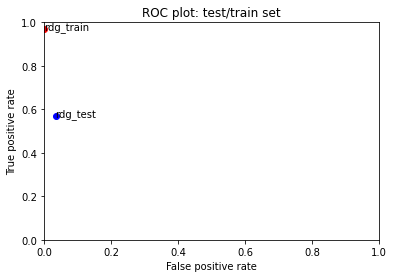

In [29]:
fits = [rdg_performance_test, rdg_performance_train]

plt.plot(fits[0].performance_measures['FP'] / fits[0].performance_measures['Neg'], 
fits[0].performance_measures['TP'] / fits[0].performance_measures['Pos'], 'bo',
fits[1].performance_measures['FP'] / fits[1].performance_measures['Neg'], 
fits[1].performance_measures['TP'] / fits[1].performance_measures['Pos'], 'ro')

for fit in fits:
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test/train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_test.csv', my_random_seed=95, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclaim_count
0          72          10              0
1          13           1              0
2          16           0              0
3          38           3              0
4           7           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5004374396072184


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count,exclaim_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation